*Теоретический материал:* https://youtu.be/n6vz5OZHKZ8?t=4

# **Import библиотек**

*Разбор данного раздела:* https://youtu.be/n6vz5OZHKZ8?t=789

In [ ]:
from google.colab import files #модуль для загрузки файлов в colab

%tensorflow_version 2.x 
import tensorflow as tf #загружаем версию tensorflow 2.x для корректной работы данного скрипта. Текущая версия по умолчанию - 1.x

from tensorflow.keras.preprocessing.text import Tokenizer #загружаем токенизатор кераса для предобработки текстовых данных
from tensorflow.keras.preprocessing.sequence import pad_sequences #метод для формирования последовательностей одинаковой длины
from tensorflow.keras.models import Model #загружаем абстрактный класс базовой модели сети от кераса
from tensorflow.keras.layers import Dense, Embedding, GRU #из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import Adam #из кераса загружаем выбранный оптимизатор
from tensorflow.keras.losses import SparseCategoricalCrossentropy #из кераса загружаем выбранную функцию потерь
import numpy as np #библиотека для работы с массивами данных

# Библиотека для визуализации данных
import matplotlib.pyplot as plt #интерфейс для построения графиков простых функций
import matplotlib.ticker as ticker # модуль для определения форматирования и местоположения делений на осях графиков.

from sklearn.model_selection import train_test_split #модуль для разбивки данных на обучающую и тестовую выборки
import re #модуль для работы с регулярными выражениями(воспользуемся в предобработке данных)
import time #модуль для работы с временем
import os #модуль для работы с операционной системой(воспользуемся методами работы с каталогами)

# **Загрузка и парсинг данных**

In [ ]:
# Загрузить по ссылке с гугл драйва
# path_to_txt = tf.keras.utils.get_file('eng-rus_dictionary.txt', origin='https://drive.google.com/uc?export=download&id=1phlxAS_QBq65_WmadLLIeTqqHArXQbSR')
# path_to_file = os.path.dirname(path_to_txt)+"/eng-rus_dictionary.txt"

In [ ]:
files.upload() #загружаем файл с базой(англо-русский словарь)
# Базы с различными языками можно скачать здесь http://www.manythings.org/anki/.

Saving eng-rus_dictionary.txt to eng-rus_dictionary.txt


In [ ]:
path_to_file = '/content/eng-rus_dictionary.txt' #указываем путь к загруженному файлу(по умолчанию сохраняется в папке content в левой панели)

In [ ]:
######################
# Предобработка предложений(очищаем от мусора, формируем нужную структуру слов и фраз)
######################
def preprocess_sentence(phrases): # функция принимает содержимое словаря
  # Разделяем пробелами слова и знаки препинания("А как насчет тебя? " -> "А как насчет тебя ? ") 
  phrases = re.sub(r"([?.!,;:])", r" \1 ", phrases) # r" \1 " берёт значения 1й группы в скобках; обрамляем указанные символы пробелами

  # Заменяем всё на пробелы, за исключением (a-zA-Zа-яёА-ЯЁ?.!,;:)
  phrases = re.sub(r"[^a-zA-Zа-яёА-ЯЁ?.!,;:]+", " ", phrases) # (a-zA-Zа-яёА-ЯЁ) - английский и русский алфавит

  phrases = phrases.rstrip().strip() #получаем строку без случайных лишних пробелов в конце фраз(rstrip удаляет с конца строки)
  phrases = '<start> ' + phrases + ' <end>' #для нашей модели обозначим тегами начало и конец предложения
  return phrases # функция возвращает предобработанные фразы
print("Фразы после обработки функцией с т.з. пунктуации примут вид:")
print(preprocess_sentence("What about you?"))
print(preprocess_sentence("А как насчет тебя?"))

Фразы после обработки функцией с т.з. пунктуации примут вид:
<start> What about you ? <end>
<start> А как насчет тебя ? <end>


In [ ]:
def create_dataset(path, num_examples): #функция принимает путь к файлу и выбранное количество пар-фраз из базы, которое возьмем в работу

''' Функция возвращает максимальную длину элемента тензора
    
    Args: 
        tensor - тензор (фразы в виде последовательности индексов)

    Return: 
        значение максимальной длины его элемента

    '''
  # Открываем файл и разбиваем фразы на отдельные строчки
  lines = open(path, encoding='UTF-8').read().strip().split('\n')
  # В каждой строке словаря разделяем английскую фразу от русской, и пропускаем через функцию предобработки данных
  word_pairs = [[preprocess_sentence(phrases) for phrases in l.split('\t')]  for l in lines[:num_examples]]
  return zip(*word_pairs) #сцепляем пары фраз в виде [по-английски, по-русски]

print("Взглянем на пример пары фраз на выходе функции:")
english, russian = create_dataset(path_to_file, None) #вызовем функцию для демонстрации
print(english[-1]) #выведем последний элемент из списка английских фраз
print(russian[-1]) #выведем последний элемент из списка русских фраз

Взглянем на пример пары фраз на выходе функции:
<start> Doubtless there exists in this world precisely the right woman for any given man to marry and vice versa ; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> Несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . Но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с учётом ми

In [ ]:
def max_length(tensor):  

''' Функция возвращает максимальную длину элемента тензора
    
    Args: 
        tensor - тензор (фразы в виде последовательности индексов)

    Return: 
        значение максимальной длины его элемента

    '''
  return max(len(t) for t in tensor) 

In [ ]:
def tokenize(language):  

''' Функция преобразования текстов в последовательности индексов
    
    Args: 
        language - текст одного из языков

    Return: 
        tensor - последовательность индексов (назовем ее тензор) 
        language_tokenizer - переменная, ссылающуюся на токенизатор

    '''
  
  # вызываем класс Токенизатор, просим его не удалять символы, которые он удаляет по умолчанию
  language_tokenizer = Tokenizer(filters='') 
  
  # подаем ему тексты для обработки и сборки словаря частотности
  language_tokenizer.fit_on_texts(language) 
  
  # разбиваем текст фраз на последовательности индексов
  tensor = language_tokenizer.texts_to_sequences(language) 
  
  # делаем последовательности фиксированной длины, заполняя нулями более короткие фразы
  tensor = pad_sequences(tensor, padding='post') 

  return tensor, language_tokenizer  

In [ ]:
def load_dataset(path, num_examples=None):  

''' Функция формирует итоговый датасет с использованием предыдущих функций
    
    Args: 
        path - путь к базе  
        num_examples - выбранный объем примеров анг-рус словаря

    Return: 
        input_tensor - тензор для русского языка
        target_tensor - ... и английского языка
        inp_language_tokenizer - токенизаторы для русского
        targ_language_tokenizer - ... и английского языков

    '''
    
    # Из исходного текста делаем датасет пар фраз, причём входным языком для сети сделаем русский
    targ_language, inp_language = create_dataset(path, num_examples)

    # Разбиваем поток текста на последовательность индексов(назовем ее тензор)
    input_tensor, inp_language_tokenizer = tokenize(inp_language) #формируем тензоры и токенизатор для русского языка
    target_tensor, targ_language_tokenizer = tokenize(targ_language) #формируем тензоры и токенизатор для английского языка

    return input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer

In [ ]:
######################
# Формирование датасета заданного объема(в зависимости от приоритета скорости либо качества обучения)
######################
num_examples = 40000 #выберем 40 тысяч строк(всего в базе около 360тысяч строк, в каждой пара фраз)
input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer = load_dataset(path_to_file, num_examples)

# Вычислим максимальные длины тензоров для английского и русского языков, используя ранее заданную функцию
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Создаем тренировочную и тестовую выборки по формуле 80/20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Визуализируем собранные данные
def convert(language, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, language.index_word[t]))
print ("Фраза на русском языке; соответствие индекса и слова")
convert(inp_language_tokenizer, input_tensor_train[0])
print ()
print ("Фраза на английском языке; соответствие индекса и слова")
convert(targ_language_tokenizer, target_tensor_train[0])
print ()
print("Рус.яз. тренировочная: " , len(input_tensor_train), "фраз; ", "Анг.яз. тренировочная: ", len(target_tensor_train), "фраз")
print("Рус.яз. тестовая: ", len(input_tensor_val), "фраз; ", "Анг.яз. тестовая: ", len(target_tensor_val), "фраз")

Фраза на русском языке; соответствие индекса и слова
1 ----> <start>
4 ----> я
71 ----> сделал
491 ----> два
3 ----> .
2 ----> <end>

Фраза на английском языке; соответствие индекса и слова
1 ----> <start>
4 ----> i
122 ----> made
339 ----> two
3 ----> .
2 ----> <end>

Рус.яз. тренировочная:  32000 фраз;  Анг.яз. тренировочная:  32000 фраз
Рус.яз. тестовая:  8000 фраз;  Анг.яз. тестовая:  8000 фраз


# **Параметры нейросети**

*Разбор данного раздела:* https://youtu.be/n6vz5OZHKZ8?t=1334

In [ ]:
######################
# Создаем tf.data датасет (Раздел tf.data.Dataset API предлагает построить готовый конвейер для обучения моделей)
######################
# Метод .shuffle с параметром BUFFER_SIZE задаст случайность подачи тренировочных сэмплов в процессе обучения(против переобучения) 
BUFFER_SIZE = len(input_tensor_train) #укажем что случайно сэмплировать будем по всей длине обучающейся выборки

BATCH_SIZE = 64 #указываем размер батча
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE # укажем количество шагов в одной эпохе
embedding_dim = 256 #размерность эмбеддинга, векторного пространства
units = 1024 #задаем размер слоя(количество нейронов в слое) 
vocab_inp_size = len(inp_language_tokenizer.word_index)+1 #задаем размер русского словаря
vocab_tar_size = len(targ_language_tokenizer.word_index)+1 #задаем размер английского словаря

# Создаём датасет из массивов Numpy(рус и анг тренировочные фразы) со случайной подачей тренировочных сэмплов в процессе обучения
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# Посмотрим на форму примеров полученных батчей
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 12]), TensorShape([64, 9]))

# **Создаём классы Encoder, Attention, Decoder**

*Разбор данного раздела:* https://youtu.be/n6vz5OZHKZ8?t=1500

In [ ]:
######################
# Создаем класс для кодировщика Encoder
######################
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz): #указываем атрибуты класса
    super(Encoder, self).__init__() #даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz #атрибут возвращает размер батча
    self.enc_units = enc_units #атрибут возвращает размер слоя в кодировщике
    self.embedding = Embedding(vocab_size, embedding_dim) #атрибут эмбеддинга - слой Кераса с размером словаря на входе и с dim=256
    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки
    self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  # Метод принимает входную фразу и начальное состояние
  def call(self, x, hidden): #при обращении к экземпляру класса как к функции, будет вызываться этот метод:
    x = self.embedding(x) # входящие тензоры преобразовываются в эмбеддинг
    output, state = self.gru(x, initial_state = hidden) #затем пропускаются через GRU и получаем выход + новое состояние
    return output, state #вызов метода/функции вернёт выход из сети GRU и состояние на выходе

  def initialize_hidden_state(self): #создаем метод инициализации состояний на скрытых слоях
    return tf.zeros((self.batch_sz, self.enc_units)) #задаем начальное состояние как размер батча на размер слоя
    
#  input tensor(фраза в виде индексов)---->Encoder----> output(значение на выходе) и hidden_state(состояние на выходе)

In [ ]:
# Создадим модель кодировщика по уже заданным параметрам 
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# Подадим в качестве примера какой-то сэмпл(Тензор[64, 12]) на вход Encoder'у и визуализируем, что получим

sample_hidden = encoder.initialize_hidden_state() #инициализируем начальное скрытое состояние
# Даем Encoder'у сэмпл и начальное состояние, и получим выход из сети GRU и состояние на выходе (вызывается метод call класса Encoder)
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Размеры выхода из кодировщика: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Размеры скрытого состояния: (batch size, units) {}'.format(sample_hidden.shape))

Размеры выхода из кодировщика: (batch size, sequence length, units) (64, 12, 1024)
Размеры скрытого состояния: (batch size, units) (64, 1024)


In [ ]:
######################
# Создаем класс Attention для внедрения механизма внимания
######################
class BahdanauAttention(Model): #название класса именем создателя механизма Дмитрия Богданова(Bahdanau)
  def __init__(self, units): # создаем слой внимания из указанного кол-ва нейронов
    super(BahdanauAttention, self).__init__() #даем возможность использовать и исполнять методы класса-родителя в классе потомке
    self.W1 = Dense(units) #атрибут: получаем веса, пропуская через полносвязный слой
    self.W2 = Dense(units) #атрибут: получаем веса, пропуская через полносвязный слой
    self.V =  Dense(1) #атрибут: пропускаем через Dense с одним нейроном, получаем отдельный вес на каждый такт

  def call(self, hidden_state, values): 
    # Форма состояния на скрытом слое (batch_size, hidden size)
    # Форму состояния на каждом такте увеличим до (batch_size, 1, hidden size)
    # Добавляем это для того, чтобы получить оценку
    hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

    # Форма оценки score (размер батча, макс.длина слов на входе, 1), однёрка в конце, чтобы применить self.V
    # До применения self.V оценка была бы (размер батча, макс.длина слов на входе, количество нейронов в слое)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # К полученной оценке применим Софтмакс, который покажет вероятность полезности от 0 до 1 для каждого слова в фразе для декодера
    # Форма оценки score - (размер батча, макс.длина слов на входе, 1); Софтмакс применяем к оси "макс.длина слов"
    attention_weights = tf.nn.softmax(score, axis=1)

    # Построим вектор контекста 
    context_vector = attention_weights * values # веса внимания перемножим со значениями(выхода из кодировщика)
    # Сумму также применяем по оси "макс.длина слов на входе"
    context_vector = tf.reduce_sum(context_vector, axis=1) #размеры вектора контекста после суммирования будут (размер батча, размер слоя)

    return context_vector, attention_weights #возвращает вектор контекста и веса внимания

# encoder hidden state и  output ---->Attention Layer----> context vector(вектор контекста) и attention weights (веса внимания)

In [ ]:
# Проверим, как работает слой
attention_layer = BahdanauAttention(10)
# Подадим на вход слою внимания выход из Encodera и его состояние, и получим значение и веса внимания
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Размеры значения внимания: (размер батча, размер слоя) {}".format(attention_result.shape))
print("Размеры весов внимания: (размер батча, длина последовательности, 1) {}".format(attention_weights.shape))

Размеры значения внимания: (размер батча, размер слоя) (64, 1024)
Размеры весов внимания: (размер батча, длина последовательности, 1) (64, 12, 1)


In [ ]:
######################
# Создаем класс для декодировщика Decoder
######################
class Decoder(Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__() #даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz #атрибут возвращает размер батча
    self.dec_units = dec_units #атрибут возвращает размер слоя в декодере(кол-во нейронов)
    self.embedding = Embedding(vocab_size, embedding_dim) #атрибут эмбеддинга - слой Кераса с размером словаря на входе и (dim=256) на выходе

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки    
    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc = Dense(vocab_size) #атрибут вызовет полносвязный слой с размером словаря

    self.attention = BahdanauAttention(self.dec_units) #атрибут подключит механизм внимания, описанный ранее

  def call(self, x, hidden, enc_output):
    # enc_output размеры (batch_size, max_length, hidden_size - размер батча, макс.длина фраз, разм.скр.слоя)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # входящий тензор слова пропускаем через эмбеддинг (получаем размеры batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # дальше конкатенируем с вектором контекста (получаем размеры batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x)

    # output размеры (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # пропускаем через полносвязный слой
    x = self.fc(output) #output размеры (batch_size, vocab)

    return x, state, attention_weights

In [ ]:
# Проверим работу декодера, подав на вход случайный массив с нужной размерностью
# Создали декодер с параметрами(размер анг.словаря, размерность эмбеддинга, кол-во нейронов, размер батча)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
# Подаём на вход случайный массив с нужной размерностью, состояние и выход с кодировщика
sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), sample_hidden, sample_output)

print ('Размер выхода с декодера: (размер батча, размер словаря) {}'.format(sample_decoder_output.shape))

Размер выхода с декодера: (размер батча, размер словаря) (64, 11756)


In [ ]:
######################
# Определяем функцию потерь
######################
optimizer = Adam() # из оптимизаторов кераса выбираем Adam
# Используем SparseCategoricalCrossentropy, к-я может работать не с категориальными лейблами
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') #логит - тензор к к-му применим софтмакс

def loss_function(real, pred): # Запишем функцию потерь, на вход подаем фактический и предсказанный результат
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #накидываем "маску" которая оставит для работы ненулевые значения
  loss_ = loss_object(real, pred) #фактические и предсказанные результаты передаем в SparseCategoricalCrossentropy и получаем ошибку

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  #reduce_mean - среднее любого выбранного тензора
  return tf.reduce_mean(loss_)

# **Обучение Нейросети**

*Разбор данного раздела:* https://youtu.be/n6vz5OZHKZ8?t=2075

In [ ]:
# Сохраняем процесс обучения модели чекпоинтами тензорфлоу
checkpoint_dir = './training_checkpoints' #даем ссылку на директорию
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt") #добавляем префикс "ckpt"
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder) #сохраняем состояния/показатели оптимизатора и моделей

In [ ]:
######################
# Создадим функцию запуска обучения модели 
######################
@tf.function
def train_step(inp, targ, enc_hidden): #функция принимает тензоры(фразы в виде индексов) и состояние в кодировщике
  loss = 0 #создаем переменную, в которую будем записывать ошибку

  # Все операции по вычислению градиента записываются на ленту(tape) и мы получаем к ним доступ
  with tf.GradientTape() as tape:
    # Передаем тензор и начальное состояние в кодировщик и получим выход и состояние на выходе
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden #передадим это состояние декодеру

    # Передаем в качестве входа в декодер индекс токена "<start>"
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Техника "Teacher forcing" - подаем предыдущее выходное слово на вход следущего в декодере. Targ.shape[64, 9]
    for t in range(1, targ.shape[1]): #для каждого слова из английской фразы
      # Передаем в обработку декодеру начальный токен, состояние на выходе из кодера, и выход из кодера
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) # Получаем от декодера предсказание и обновленное состояние
      # Обновляем ошибку для текущих предсказаний
      loss += loss_function(targ[:, t], predictions)

      # Используем "Teacher forcing"
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1])) # Получаем ошибку на батче . Targ.shape[64, 9]. Делим на 9

  variables = encoder.trainable_variables + decoder.trainable_variables # создаем переменные, для которых TensorFlow будет вычислять градиенты

  gradients = tape.gradient(loss, variables) #отслеживаем градиент
  
  optimizer.apply_gradients(zip(gradients, variables)) #оптимизируем веса

  return batch_loss #функция обучения вернет ошибку на батче

In [ ]:
######################
# Запуск обучения
######################
EPOCHS = 30 #устанавливаем количество эпох

for epoch in range(EPOCHS): #на каждой эпохе
  start = time.time() #включаем счетчик времени

  enc_hidden = encoder.initialize_hidden_state() #задаем начальное состояние на скрытом слое encodera
  total_loss = 0 #начальное значение итоговой ошибки

  # Для батча, входного и выходного тензора на каждом шаге эпохи
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden) #передадим в функцию тензоры и состояние в кодировщике, обучим и получим ошибку на батче
    total_loss += batch_loss #добавим ее в итоговую ошибку

  # Каждые 10 эпох будем сохранять чекпоинты
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  # Выведем показатели после каждой эпохи
  print('Эпоха {} Ошибка {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Время на 1 эпоху {} сек\n'.format(round(time.time() - start), 1))

Эпоха 1 Ошибка 2.1200
Время на 1 эпоху 58 сек

Эпоха 2 Ошибка 1.3229
Время на 1 эпоху 49 сек

Эпоха 3 Ошибка 0.8588
Время на 1 эпоху 49 сек

Эпоха 4 Ошибка 0.5412
Время на 1 эпоху 49 сек

Эпоха 5 Ошибка 0.3493
Время на 1 эпоху 49 сек

Эпоха 6 Ошибка 0.2365
Время на 1 эпоху 49 сек

Эпоха 7 Ошибка 0.1698
Время на 1 эпоху 49 сек

Эпоха 8 Ошибка 0.1334
Время на 1 эпоху 49 сек

Эпоха 9 Ошибка 0.1084
Время на 1 эпоху 49 сек

Эпоха 10 Ошибка 0.0937
Время на 1 эпоху 50 сек

Эпоха 11 Ошибка 0.0855
Время на 1 эпоху 49 сек

Эпоха 12 Ошибка 0.0794
Время на 1 эпоху 49 сек

Эпоха 13 Ошибка 0.0752
Время на 1 эпоху 49 сек

Эпоха 14 Ошибка 0.0712
Время на 1 эпоху 49 сек

Эпоха 15 Ошибка 0.0693
Время на 1 эпоху 49 сек

Эпоха 16 Ошибка 0.0676
Время на 1 эпоху 49 сек

Эпоха 17 Ошибка 0.0653
Время на 1 эпоху 49 сек

Эпоха 18 Ошибка 0.0618
Время на 1 эпоху 49 сек

Эпоха 19 Ошибка 0.0597
Время на 1 эпоху 49 сек

Эпоха 20 Ошибка 0.0597
Время на 1 эпоху 50 сек

Эпоха 21 Ошибка 0.0584
Время на 1 эпоху 49 сек

Э

In [ ]:
######################
# Функция запуска и оценки модели переводчика
######################
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp)) # создаем начальные настройки графика внимания

    sentence = preprocess_sentence(sentence) #предобрабатываем предложение

    inputs = [inp_language_tokenizer.word_index[i] for i in sentence.split(' ')] #преобразовываем в послед-ть индексов
    inputs = pad_sequences([inputs], maxlen=max_length_inp, padding='post') # делаем паддинг
    inputs = tf.convert_to_tensor(inputs) #конвертируем в тф тензор

    result = '' #сюда запишем результат

    hidden = [tf.zeros((1, units))] #задаем начальное состояние
    enc_out, enc_hidden = encoder(inputs, hidden) #передаем его и входной тензор и получаем выход с кодера и состояние

    dec_hidden = enc_hidden #состояние кодера передаем в декодер
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']], 0) #передаем на вход декодеру <start> в виде индекса

    for t in range(max_length_targ): #идем по макс.длине фраз выходного языка(анг)
        # Прогоняем через декодер входящий тензор, состояние с выхода кодера, выход с кодера
        # Получаем результат предсказания, обновленное состояние, и веса внимания
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Сохраняем веса внимания для графика
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        # Аргмаксом вытаскиваем предсказанное слово
        predicted_id = tf.argmax(predictions[0]).numpy()
        # Результат конвертируем из индекса в слово и ложим в result = ''
        result += targ_language_tokenizer.index_word[predicted_id] + ' '
        # Если предсказанное слово - <end>, то останавливаемся, возвращаем результаты, выводим на графике
        if targ_language_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # предсказанное значение подается обратно в модель
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# Создаем функцию для построение плота с весами внимания
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence): # функция принимает предложение и выводит результат с визуализацией
    result, sentence, attention_plot = evaluate(sentence)

    print('Входящая фраза: %s' % (sentence))
    print('Предсказанный перевод: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# Воспроизведём последний сохранённый чекпоинт
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Входящая фраза: <start> давайте дружить <end>
Предсказанный перевод: let s be friends . <end> 


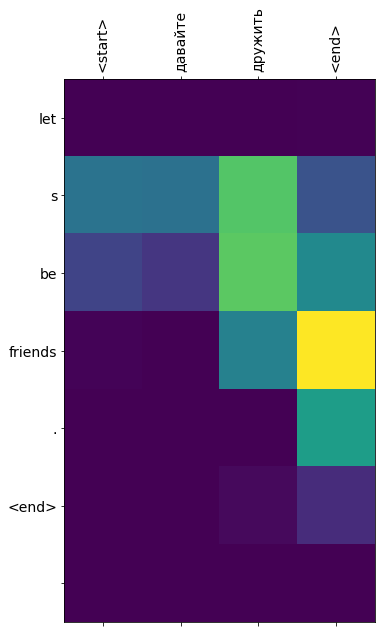

In [ ]:
# И, наконец, переведём предложение и выведем визуализацию
translate('давайте дружить')

Входящая фраза: <start> у тебя всё хорошо <end>
Предсказанный перевод: you re ok . <end> 


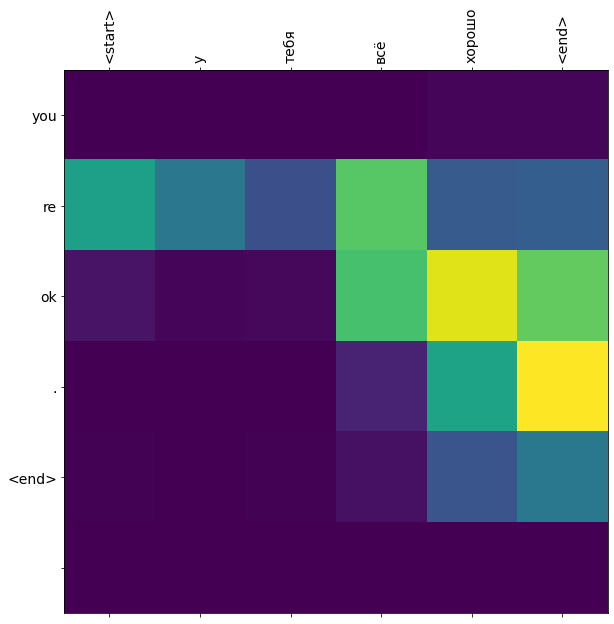

In [ ]:
translate('у тебя всё хорошо')

Входящая фраза: <start> у тебя всё хорошо ? <end>
Предсказанный перевод: are you ok ? <end> 


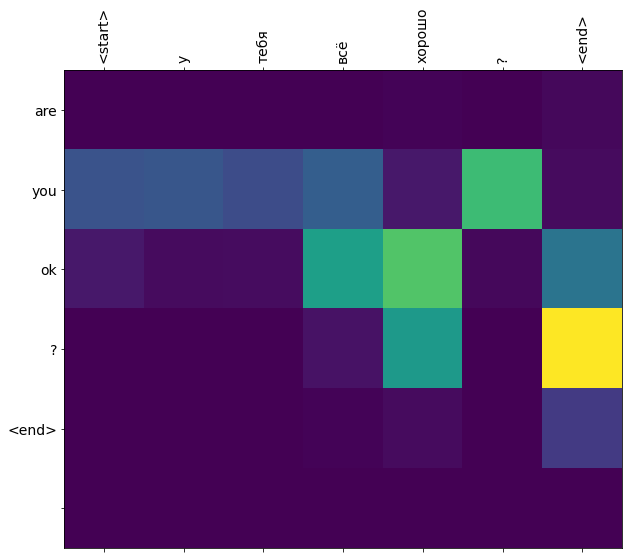

In [ ]:
translate('у тебя всё хорошо?')

In [ ]:
translate('Нефть упала в стоимости до 30 долларов за баррель')

KeyError: ignored